# Graph Classification

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_generator import  * 
from GNN_models import *

import torch
from torch_geometric.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Importing data

In [22]:
#x_aug = np.load("x_aug.npz", allow_pickle = True)['datadict_list'][0]
x_true = np.load("x_true.npz", allow_pickle = True)['datadict_list'][0]
#y_aug = np.load("y_aug.npz", allow_pickle = True)['y_aug']
y_true = np.load("y_true.npz", allow_pickle = True)['y']
true_raw = np.load("true_raw_attribution_datadicts.npz", allow_pickle = True)["datadict_list"]

### Generating data

In [24]:
# Generating training & test data
data_model = molecular_data_generator(x_true, y_true)
data_model.data_generation()

12000it [00:00, 33419.20it/s]


In [19]:
train_data = data_model.out_list[:10000]
test_data = data_model.out_list[10000:]

data_module = DataLoader(train_data, 
                        batch_size = 100)

### Model

In [25]:
nn_conv = benzene_NNConv(data_model.out_list[0], 
                        device = "cuda")

### Graph classification

In [8]:
model = benzene_NNConv(data_model.out_list[0]).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model.train()
for epoch in range(15):
    for data in data_module : 
        data.to(device)
        optimizer.zero_grad()
        out = model(data = data, 
                   training_with_batch = True)
        loss = F.binary_cross_entropy(out.view(-1), data.y)
        loss.backward()
        optimizer.step()
    print(loss)

C:\Users\kswoo\Anaconda3\envs\sunwoo_env\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.0745, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0005, devic

### Test data evaluation

In [43]:
acc = 0 
entire_emb = np.zeros(16).reshape(1,-1)
for data in tqdm(test_data) : 
    pred_y = model(data.to(device), 
         training_with_batch = False)
    emb = model.embeddings
    entire_emb = np.vstack([entire_emb, emb.to("cpu").detach().numpy().reshape(1,-1)])
    if data.y.to("cpu").item() > 0.5 : 
        if pred_y.to("cpu").detach().item() > 0.5 : 
            acc += 1
    else : 
        if pred_y.to("cpu").detach().item() < 0.5 : 
            acc += 1
entire_emb = entire_emb[1:, :]

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]C:\Users\kswoo\Anaconda3\envs\sunwoo_env\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1026.46it/s]


Model Accuracy

In [38]:
acc/len(test_data)

0.9985

### Visualizing embedding

In [60]:
test_y = y_true[1000:, ]
benz = np.where(test_y.reshape(-1) == 1)[0]
no_benz = np.where(test_y.reshape(-1) == 0)[0]

In [62]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(test_y)

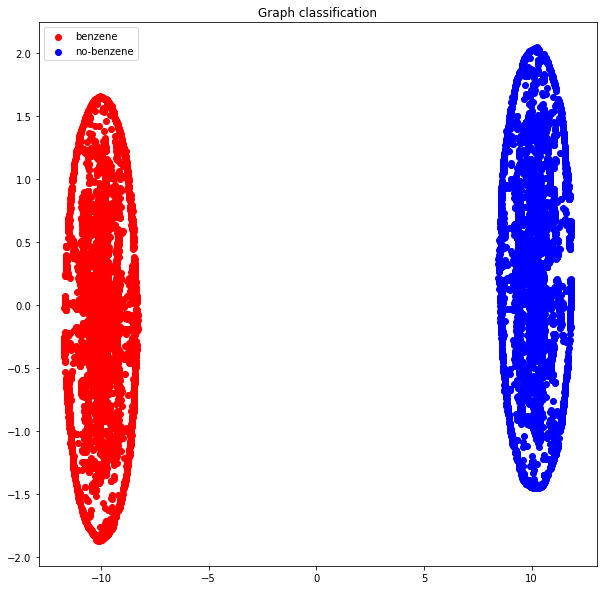

In [65]:
plt.figure(figsize = (10,10))
plt.title("Graph classification")
plt.scatter(X_embedded[benz, 0], X_embedded[benz, 1], color = "red", label = "benzene")
plt.scatter(X_embedded[no_benz, 0], X_embedded[no_benz, 1], color = "blue", label = "no-benzene")
plt.legend()

### Appendix. Checking the ID of mol

In [31]:
smile = pd.read_csv("benzene_smiles.csv")

In [32]:
smile

,mol_id,smiles,mol,label
0,ZINC72292955,c1cc(ncc1NC(=O)C1CCCCC1)n1cc(cn1)S(=O)(=O)N,<rdkit.Chem.rdchem.Mol object at 0x7f933b6e5c10>,0.0
1,ZINC66294494,C[C@H](C(=O)Nc1ccccc1F)[S@@](=O)C/C=C/c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7f933b55cb70>,1.0
2,ZINC07601739,c1ccc(cc1)CNn1c(nnn1)N,<rdkit.Chem.rdchem.Mol object at 0x7f933b63c300>,1.0
3,ZINC04127898,CC(=O)N(C)c1ccc(c2c1cccc2)[N+](=O)[O-],<rdkit.Chem.rdchem.Mol object at 0x7f933b3c9bc0>,1.0
4,ZINC33699343,CC(=O)/C(=C/NCCN1CCOCC1)/C(=O)Nc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7f933b320b20>,1.0
...,...,...,...,...
11995,ZINC89389574,C[C@]1(CCCS1)C(=O)N[C@H](COC)C(=O)N,<rdkit.Chem.rdchem.Mol object at 0x7f933b6c84e0>,0.0
11996,ZINC12618996,Cc1nc(cs1)c1ccc(o1)CNC(=O)COc1ccc(cc1Br)Br,<rdkit.Chem.rdchem.Mol object at 0x7f933b39f300>,1.0
11997,ZINC03075348,CCOC(=O)[C@H](C)C(=O)NC,<rdkit.Chem.rdchem.Mol object at 0x7f933b49a7b0>,0.0
11998,ZINC12359546,CCOC(=O)/C=C/c1cnccc1NC(=O)C,<rdkit.Chem.rdchem.Mol object at 0x7f933ac88ad0>,0.0
